<h1><center>Data Analytics on Player Performance in Major League Baseball</center></h1>
<h2><center>Chris Emm</center></h2>

In [56]:
import sqlite3
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
import requests
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)

### Introduction

In order to successfully run a Major League Baseball team, you need to have talented players. Over the years, the definition of what makes players talented has been fluid.

Is it a player who hits a lot of homeruns but strikes out a lot?
<br />Is it a player who might not hit the cover off the ball but fields every play perfectly?
<br />Is it a guy who just gets on base a ton?

The true answer, is all of the above. Every team is going to need people who get on base, people who can drive in runs with one swing of the bat, and people who are great defenders. Now, there are certainly plenty of players who fit within these definitions, however, they normally don't come at a bargain. The goal of this analysis is to determine the *'diamond in the rough type players'* -- the players who are sneakily talented and yet are undervalued, and underpaid. This project will walk you through what makes a player valuable, and how that player's talents can relate to putting up wins for the team he is on, all while identifying the players who came at a bargain based on the talent they brought to the field.

### Part I: Scraping Basic Position Player Data for 2011-2021 Seasons

First, we will need to scrape data from multiple different sources.

**Sean Lahman's Batting Dataset:**
> Contains batting data through the 2021 season.

**Sean Lahman's People Dataset:**
> Contains player information such as birth year, name, etc.

**Sean Lahman's Appearances Dataset:**
> Contains data on how many games a player played at each position throughout the season.
<br />We will use this to remove the pitchers from the batting dataset.

**Sean Lahman's Salary Dataset:**
> Contains player salaries for each year up through 2016. For 2016-Present, we will list it as NaN.


In [57]:
# Create dataframe of player information like name and age
player_table = pd.read_csv('tables/People.csv')
shortened_player = player_table[['playerID','nameFirst', 'nameLast', 'birthYear']]
shortened_player = shortened_player.assign(Name = shortened_player.nameFirst.str.cat(shortened_player.nameLast,sep=' '))
shortened_player = shortened_player[['playerID', 'Name', 'birthYear']]

# Create dataframe of batting statistics
batting_table = pd.read_csv('tables/Batting.csv')
batting_table = batting_table[batting_table.yearID > 2010]

# Combine the pitching and batting stats
batting_table = pd.merge(batting_table, shortened_player, on='playerID')

# Rename columns
batting_table = batting_table.rename(columns={'teamID':'Team', 'lgID':'Lg', 'yearID':'Year'})

# Grabbing only needed columns
batting_table = batting_table[['playerID', 'Name', 'Year','Team', 'Lg', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', \
                             'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP']]

# Changing columns to be ints instead of floats
#full_batting.Age = full_batting.Age.astype(int)
batting_table.RBI = batting_table.RBI.astype(int)
batting_table.SB = batting_table.SB.astype(int)
batting_table.CS = batting_table.CS.astype(int)
batting_table.SO = batting_table.SO.astype(int)
batting_table.IBB = batting_table.IBB.astype(int)
batting_table.HBP = batting_table.HBP.astype(int)
batting_table.SH = batting_table.SH.astype(int)
batting_table.SF = batting_table.SF.astype(int)
batting_table.GIDP = batting_table.GIDP.astype(int)
                          
# Sort by year and then reset the index
batting_table = batting_table.sort_values('Year')
batting_table = batting_table.reset_index(drop=True)

batting_table

,playerID,Name,Year,Team,Lg,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abadfe01,Fernando Abad,2011,HOU,NL,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,fisheca01,Carlos Fisher,2011,CIN,NL,17,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,figuene01,Nelson Figueroa,2011,HOU,NL,8,9,0,2,0,0,0,0,0,0,0,2,0,0,1,0,0
3,figgich01,Chone Figgins,2011,SEA,AL,81,288,24,54,11,1,1,15,11,6,21,42,1,0,2,2,6
4,salech01,Chris Sale,2011,CHA,AL,58,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16269,flaheja01,Jack Flaherty,2021,SLN,NL,17,17,2,2,0,0,1,3,0,0,5,7,0,0,3,1,0
16270,flexech01,Chris Flexen,2021,SEA,AL,31,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
16271,fowledu01,Dustin Fowler,2021,PIT,NL,18,41,3,7,1,0,0,2,1,0,3,20,0,1,0,1,0
16272,farmeky01,Kyle Farmer,2021,CIN,NL,147,483,60,127,22,2,16,63,2,3,22,97,1,18,1,5,16


Because pitchers can also bat (and they were required to in the National League until 2022), this dataset includes pitchers. For example, Jack Flaherty is a starting pitcher for the St. Louis Cardinals, and he is included in the dataset. However, we want to remove these pitchers and focus only on true position players batting. We will take care of this is the next section.

#### Removing Pitchers from Batting Table (Except for Shohei Ohtani)

Since pitchers are in the dataset too, and most of the time, pitchers are poor hitters, I do not want to include them, as it would skew the dataset. The only exception I am going to make is Shohei Ohtani, who is the only two-way player in MLB. He was so successful that in 2021, he made the All-Star game as both a Designated Hitter, as well as Pitcher, and he also won the AL MVP award. Obviously, we want to include someone as talented as Ohtani in our data. In the below code snippet, I am taking the max number of appearances at each position for each player and whichever position, the max came at, is considered their position. Since Othani will appear in more games at DH than he does as Pitcher, he will remain in the dataset.

In [58]:
player_pos = pd.read_csv('tables/Appearances.csv')
player_pos = player_pos[['playerID', 'yearID', 'G_p', 'G_c', 'G_1b', 'G_2b', 'G_3b', 'G_ss', 'G_lf', 'G_cf', 'G_rf', 'G_dh']]
player_pos = player_pos[player_pos.yearID > 2010]
player_pos = player_pos.rename(columns = {'yearID':'Year', 'G_p':'P', 'G_c':'C', 'G_1b':'1B', 'G_2b':'2B', 'G_3b':'3B', 'G_ss':'SS', 'G_lf':'LF', 'G_cf':'CF', 'G_rf':'RF', 'G_dh':'DH'})
player_pos = player_pos.astype({'DH':'int32'})

positions = player_pos[['P', 'C', '1B', '2B', '3B', 'SS', 'LF', 'CF', 'RF', 'DH']]

positions = positions.assign(Pos = positions.idxmax(axis=1))

player_pos = pd.merge(player_pos, positions, on = ['P', 'C', '1B', '2B', '3B', 'SS', 'LF', 'CF', 'RF', 'DH'])
player_pos = player_pos[['playerID', 'Year', 'Pos']]
player_pos = player_pos.drop_duplicates()
player_pos

,playerID,Year,Pos
0,abadfe01,2011,P
133,baezda01,2011,P
266,colonba01,2011,P
399,daviswa01,2011,P
532,doteloc01,2011,P
...,...,...,...
1595012,yastrmi01,2021,RF
1595013,yelicch01,2021,LF
1595014,youngan02,2021,2B
1595015,zimmebr01,2021,CF


In [59]:
# Merge
batting_table = pd.merge(batting_table, player_pos, on=['playerID', 'Year'])

batting_table = batting_table[batting_table.Pos != 'P']
batting_table = batting_table[['Name', 'Year', 'Pos', 'Team', 'Lg', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', \
                             'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP']]
batting_table

,Name,Year,Pos,Team,Lg,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
3,Chone Figgins,2011,3B,SEA,AL,81,288,24,54,11,1,1,15,11,6,21,42,1,0,2,2,6
5,Jarrod Saltalamacchia,2011,C,BOS,AL,103,358,52,84,23,3,16,56,1,0,24,119,1,3,0,1,7
8,Thomas Field,2011,SS,COL,NL,16,48,4,13,0,0,0,3,0,0,3,14,0,0,0,0,1
11,Prince Fielder,2011,1B,MIL,NL,162,569,95,170,36,1,38,120,1,1,107,106,32,10,0,6,17
12,Angel Sanchez,2011,SS,HOU,NL,110,288,35,69,10,0,1,28,3,0,27,44,1,1,10,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16858,Phillip Evans,2021,1B,PIT,NL,76,214,23,44,5,0,5,16,1,0,28,53,1,5,0,0,3
16859,Rhys Hoskins,2021,1B,PHI,NL,107,389,64,96,29,0,27,71,3,2,47,108,0,5,0,2,7
16863,Derek Fisher,2021,RF,MIL,NL,4,8,1,2,0,1,0,1,0,0,0,1,0,0,0,0,0
16866,Dustin Fowler,2021,CF,PIT,NL,18,41,3,7,1,0,0,2,1,0,3,20,0,1,0,1,0


In [60]:
batting_table[batting_table.Name == 'Jack Flaherty']

,Name,Year,Pos,Team,Lg,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP


In [61]:
batting_table[batting_table.Name == 'Shohei Ohtani']

,Name,Year,Pos,Team,Lg,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
11339,Shohei Ohtani,2018,DH,LAA,AL,114,326,59,93,21,2,22,61,10,4,37,102,2,2,0,1,2
12396,Shohei Ohtani,2019,DH,LAA,AL,106,384,51,110,20,5,18,62,12,3,33,110,1,2,0,4,6
14337,Shohei Ohtani,2020,DH,LAA,AL,46,153,23,29,6,0,7,24,7,1,22,50,0,0,0,0,3
16343,Shohei Ohtani,2021,DH,LAA,AL,158,537,103,138,26,8,46,100,26,10,96,189,20,4,0,2,7


As you can see, Jack Flaherty is no longer in the dataset, all whilebeing able to keep Shohei Ohtani in the dataset, so it appears we have successfully removed all primary pitchers from the dataset.

#### Scrape Salaries for Players from 2011-2021

Having a discussion about player value would be worthless if we did not include the salaries for each player for every year. Unfortunately, the updated (to the end of the 2021 season) Lahman dataset did not have salaries for any of the players, nor did the baseball reference .csv file. Instead, I had to do some research and found that Cot's Baseball Contracts (https://legacy.baseballprospectus.com/compensation/cots/) had salaries for all players from 2000-2021. There were individual .csv files for each season, so using excel, I just merged them all into one table in one file. I then uploaded that file to my workspace and read it as normal (using the read_csv() function). Below is a little bit of data manipulation; just trying to get the format of the names to be the exact format that my dataframe had, so that it would smoothly merge into my dataframe.

In [62]:
salaries = pd.read_csv('salaries/salaries.csv')

# Split the Name colum into first name and last name (originally stored as 'Last, First')
# and store it as a separate dataframe
names = salaries.Player.str.split(', ', expand=True)[[0, 1]]

# Create a new column called Name that has the format 'First Last'
names = names.assign(Name = names[1].str.cat(names[0],sep=' '))

# Remove all columns except for the new name column
names = names[['Name']]

# Add the years to the names dataframe
names = names.assign(Year = salaries.Year.to_list())

# Add the salaries to the names dataframe
names = names.assign(Salary = salaries.Salary.to_list())

names.Salary = names.Salary.str.replace(',', '')
names.Salary = names.Salary.replace({'\$':''}, regex = True)

# Assign names to the salaries variable
salaries = names

salaries

,Name,Year,Salary
0,Mike Trout,2021,37116667
1,Gerrit Cole,2021,36000000
2,Jacob deGrom,2021,36000000
3,Stephen Strasburg,2021,35000000
4,Nolan Arenado,2021,35000000
...,...,...,...
11080,Brayan Villarreal,2011,414000
11081,Jordan Walden,2011,414000
11082,Ryan Webb,2011,414000
11083,Tom Wilhelmsen,2011,414000


#### Add Salaries to Batting Statistics Dataframe

Now that we have salaries for every single player in the last decade, we can merge the salary data onto the table that we have that contains the batting statistics for every single player from 2011-2021. Below is the code that achieves this.

In [63]:
batting_table = pd.merge(batting_table, salaries, on = ['Name', 'Year'])
batting_table

,Name,Year,Pos,Team,Lg,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,Salary
0,Chone Figgins,2011,3B,SEA,AL,81,288,24,54,11,1,1,15,11,6,21,42,1,0,2,2,6,9500000
1,Jarrod Saltalamacchia,2011,C,BOS,AL,103,358,52,84,23,3,16,56,1,0,24,119,1,3,0,1,7,750000
2,Prince Fielder,2011,1B,MIL,NL,162,569,95,170,36,1,38,120,1,1,107,106,32,10,0,6,17,15500000
3,Angel Sanchez,2011,SS,HOU,NL,110,288,35,69,10,0,1,28,3,0,27,44,1,1,10,2,3,432500
4,Gaby Sanchez,2011,1B,FLO,NL,159,572,72,152,35,0,19,78,3,1,74,97,4,6,2,7,18,431000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5650,Phillip Evans,2021,1B,PIT,NL,76,214,23,44,5,0,5,16,1,0,28,53,1,5,0,0,3,650000
5651,Rhys Hoskins,2021,1B,PHI,NL,107,389,64,96,29,0,27,71,3,2,47,108,0,5,0,2,7,4800000
5652,Derek Fisher,2021,RF,MIL,NL,4,8,1,2,0,1,0,1,0,0,0,1,0,0,0,0,0,582100
5653,Dustin Fowler,2021,CF,PIT,NL,18,41,3,7,1,0,0,2,1,0,3,20,0,1,0,1,0,575500


### Part II: Scraping Advanced Position Player Metrics for 2011-2021 Seasons

#### Scraping Baseball Reference for Advanced Metrics

In order to successfully analyze a player's value, we need to have more than just the basic metrics like batting average, RBI, and homeruns. We want more advanced data, such as walk rate, strikeout rate, wRC+, etc. Since our original dataset does not include this, I had to scrape data from Fangraphs and Baseball-Reference. 

Below, we are scraping WAR and OPS+ from Baseball-Reference:
<br />**WAR: Wins Above Replacement**
> Calculates many more wins a baseball team has from a player compared to if the team replaced the player with a replacement-level player in the same position.

<br />**OPS+: Normalized on-base plus slugging percentage**
> **On-Base Percentage:** The ratio of the sum of the batter's hits, walks, hit by pitches to their number of plate appearances
<br />**Slugging Percentage:** The total number of bases a player records per at-bat **(1B + 2Bx2 + 3Bx3 + HRx4)/AB**
<br />**Normalized:** Adjusts the OPS based on park factors by comparing it to league average **(OPS / league OPS) x 100**

In [64]:
# Rename Teams ID to match batting dataframe from above
batting_table = batting_table.replace('CHN', 'CHC')
batting_table = batting_table.replace('CHA', 'CHW')
batting_table = batting_table.replace('LAN', 'LAD')
batting_table = batting_table.replace('KCA', 'KCR')
batting_table = batting_table.replace('NYA', 'NYY')
batting_table = batting_table.replace('NYN', 'NYM')
batting_table = batting_table.replace('SFN', 'SFG')
batting_table = batting_table.replace('SDN', 'SDP')
batting_table = batting_table.replace('SLN', 'STL')
batting_table = batting_table.replace('WAS', 'WSN')
batting_table = batting_table.replace('TBA', 'TBR')

In [65]:
# Scrape data from baseball reference .csv file
baseball_reference_table = pd.read_csv('baseball-reference/batting.csv')
baseball_reference_table = baseball_reference_table[['Name', 'Age', 'Year', 'Team', 'WAR', 'WAR_def', 'WAR_off', 'OPS_plus']]

# Rename OPS_plus to OPS+
baseball_reference_table = baseball_reference_table.rename(columns={'OPS_plus':'OPS+'})

# Cast OPS+ column to integer
baseball_reference_table['OPS+'] = baseball_reference_table['OPS+'].fillna(0)
baseball_reference_table['OPS+'] = baseball_reference_table['OPS+'].astype(int)

# Cast Age column to integer
baseball_reference_table.Age = baseball_reference_table.Age.fillna(0)
baseball_reference_table.Age = baseball_reference_table.Age.astype(int)

# Merge dataframe from above with the nex dataframe
batting_table = pd.merge(batting_table, baseball_reference_table, on=['Name', 'Year', 'Team'])

# Reorder the columns
batting_table = batting_table[['Year', 'Name', 'Pos', 'Age', 'Team', 'Lg', 'G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', \
                               'BB', 'SO', 'IBB', 'HBP', 'SH', 'SF', 'GIDP', 'OPS+', 'WAR', 'WAR_def', 'WAR_off', 'Salary']]

batting_table

,Year,Name,Pos,Age,Team,Lg,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,OPS+,WAR,WAR_def,WAR_off,Salary
0,2011,Chone Figgins,3B,33,SEA,AL,81,288,24,54,11,1,1,15,11,6,21,42,1,0,2,2,6,40,-0.92,0.06,-0.78,9500000
1,2011,Jarrod Saltalamacchia,C,26,BOS,AL,103,358,52,84,23,3,16,56,1,0,24,119,1,3,0,1,7,94,0.73,-0.05,1.51,750000
2,2011,Prince Fielder,1B,27,MIL,NL,162,569,95,170,36,1,38,120,1,1,107,106,32,10,0,6,17,164,4.49,-2.12,5.53,15500000
3,2011,Angel Sanchez,SS,27,HOU,NL,110,288,35,69,10,0,1,28,3,0,27,44,1,1,10,2,3,65,-0.31,0.12,-0.11,432500
4,2011,Pablo Sandoval,3B,24,SFG,NL,117,426,55,134,26,3,23,70,2,4,32,63,9,0,1,7,12,155,6.00,1.73,4.40,500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5527,2021,Phillip Evans,1B,28,PIT,NL,76,214,23,44,5,0,5,16,1,0,28,53,1,5,0,0,3,68,-0.37,-0.37,-0.24,650000
5528,2021,Rhys Hoskins,1B,28,PHI,NL,107,389,64,96,29,0,27,71,3,2,47,108,0,5,0,2,7,129,1.95,-1.32,2.70,4800000
5529,2021,Derek Fisher,RF,27,MIL,NL,4,8,1,2,0,1,0,1,0,0,0,1,0,0,0,0,0,94,0.02,-0.01,0.02,582100
5530,2021,Dustin Fowler,CF,26,PIT,NL,18,41,3,7,1,0,0,2,1,0,3,20,0,1,0,1,0,20,-0.36,0.01,-0.36,575500


Next, we want to include even more metrics that were not easily accessible on Baseball-Reference. For this, we will use data from Fangraphs. Since each Fangraphs webpage only has a single team's players's stats for a given year, I had to create a function that created a dataframe by scraping the table using the given url, which was specific to a team and year. For example, one url would have the datatable for each player on the 2016 Baltimore Orioles. Since one page could only display 50 players, there were 2 pages (an additional url) for each team. Below is the function that creates the dataframe by scraping the data from the inputted url.

In [11]:
def scraping_advanced_stats(url, year, team):
    # Extracting text from webpage
    html = requests.get(url).text

    # Parsing the text into html code
    soup = BeautifulSoup(html,"html.parser")

    # Finding the table in the html code - we are searching by the id of the table
    table = soup.find("table", attrs={"class": "rgMasterTable"})


    table_data = table.tbody.find_all("tr")

    dataset = []
    for tr in table_data:
        temp = ()
        for td in tr.find_all("td"):
            if '\xa0' in td.text:
                temp += ('0.0',)
            else:
                temp += (td.text,)
        dataset.append(temp)

    advanced_stats = pd.DataFrame(data = dataset)
    advanced_stats = advanced_stats.replace(to_replace=" NULL",value=0)

    table_header = table.thead.find_all("tr")
    columns = []
    count = 0
    for tr in table_header:
        if count == 1:
            th = tr.find_all("th")
            for a in th:
                columns.append(a.text)
        count = 1
    advanced_stats.columns = columns
    advanced_stats = advanced_stats.assign(Year = year)
    advanced_stats = advanced_stats.assign(Team = team)
    
    return advanced_stats

Since I needed to generate a url for each page for each team for a given year for the years 2011-2021, I needed to create a function that generated a url for each value. See it below:

In [12]:
def get_urls(team, year, page):
    url = 'https://www.fangraphs.com/leaders.aspx?pos=all&stats' \
      '=bat&lg=all&qual=0&type=1&season=' + str(year) + '&month=0&season1=' \
       + str(year) + '&ind=0&team='+ str(team) +'&rost=0&age=0&filter=&players=0&startdate' \
      '=' + str(year) + '-01-01&enddate=' + str(year) + '-12-31&page=' + str(page) + '_50'
    return url

Below, I am actually putting the functions made above into use. With the first url, I create an initial dataframe. For the subsequent urls, I just concatenate the created dataframe onto the previous dataframes, to create a single dataframe that holds the data for each player on each team from 2011-2021. Below is the code:

In [14]:
teams = ['LAA', 'BAL', 'BOS', 'CHW', 'CLE', 'DET', 'KCR', 'MIN', 'NYY', 'OAK', \
         'SEA', 'TBR', 'TEX', 'TOR', 'ARI', 'ATL', 'CHC', 'CIN', 'COL', 'MIA', \
         'HOU', 'LAD', 'MIL', 'WSN', 'NYM', 'PHI', 'PIT', 'STL', 'SDP', 'SFG']

team_number = [i for i in range(1, 31)]
years = [i for i in range(2011,2022)]
pages = [1,2]

count = 0
for year in years:
    for team in team_number:
        for page in pages:
            url = get_urls(team, year, page)
            if count == 0:
                advanced_batting = scraping_advanced_stats(url, year, teams[team-1])
                count = 1
            else:
                advanced_batting = pd.concat([advanced_batting, scraping_advanced_stats(url, year, teams[team-1])])
    
advanced_batting = advanced_batting.drop_duplicates()
advanced_batting = advanced_batting.reset_index(drop=True)
advanced_batting

,#,Name,PA,BB%,K%,BB/K,AVG,OBP,SLG,OPS,ISO,Spd,BABIP,UBR,wGDP,wSB,wRC,wRAA,wOBA,wRC+,Year,Team
0,1,Tyler Chatwood,5,0.0%,0.0%,0.00,.667,.667,.667,1.333,.000,2.6,.667,0.0,0.0,0.0,2,1.1,.594,289,2011,LAA
1,2,Ervin Santana,2,0.0%,50.0%,0.00,.500,.500,.500,1.000,.000,0.1,1.000,0.0,0.0,0.0,0,0.2,.445,188,2011,LAA
2,3,Gil Velazquez,7,0.0%,0.0%,0.00,.500,.429,.500,.929,.000,0.1,.429,0.0,0.1,0.0,1,0.4,.382,145,2011,LAA
3,4,Howie Kendrick,583,5.7%,20.4%,0.28,.285,.338,.464,.802,.179,6.2,.338,2.3,-2.2,-0.1,81,15.4,.349,123,2011,LAA
4,5,Torii Hunter,649,9.6%,19.3%,0.50,.262,.336,.429,.765,.167,3.1,.297,1.3,-3.5,-2.4,84,10.7,.337,115,2011,LAA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16260,50,Conner Menez,0,0.0%,0.0%,0.00,.000,.000,.000,.000,.000,0.1,.000,0.0,0.0,0.0,0,0.0,.000,0.0,2021,SFG
16261,51,Caleb Baragar,2,0.0%,100.0%,0.00,.000,.000,.000,.000,.000,0.1,.000,0.0,0.0,0.0,0,-0.5,.000,-100,2021,SFG
16262,52,Kervin Castro,0,0.0%,0.0%,0.00,.000,.000,.000,.000,.000,0.1,.000,0.0,0.0,0.0,0,0.0,.000,0.0,2021,SFG
16263,53,Gregory Santos,0,0.0%,0.0%,0.00,.000,.000,.000,.000,.000,0.1,.000,0.0,0.0,0.0,0,0.0,.000,0.0,2021,SFG


#### Cleaning Dataframe Created from Web Scrape

Below you will see a naming discrepancy for players with a suffix between my first dataframe (first table displayed) and the newly created dataframe (2nd table displayed). We need to address this to be able to merge our advanced data by name.

In [20]:
batting_table[batting_table.Name == 'Cedric Mullins']

,Year,Name,Pos,Age,Team,Lg,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,OPS+,WAR,WAR_def,WAR_off,Salary
3987,2019,Cedric Mullins,CF,24,BAL,AL,22,64,7,6,0,2,0,4,1,0,4,14,0,3,2,1,2,-8,-0.54,0.17,-0.65,557500
4644,2020,Cedric Mullins,CF,25,BAL,AL,48,140,16,38,4,3,3,12,7,2,8,37,0,1,4,0,0,94,0.44,0.05,0.45,563500
5334,2021,Cedric Mullins,CF,26,BAL,AL,159,602,91,175,37,5,30,59,30,8,59,125,3,8,1,4,2,135,5.69,0.35,5.75,577000


In [21]:
advanced_batting[advanced_batting.Name == 'Cedric Mullins II']

,#,Name,PA,BB%,K%,BB/K,AVG,OBP,SLG,OPS,ISO,Spd,BABIP,UBR,wGDP,wSB,wRC,wRAA,wOBA,wRC+,Year,Team
10170,12,Cedric Mullins II,191,8.9%,19.4%,0.46,.235,.312,.359,.671,.124,2.9,.279,0.8,0.2,-0.9,20,-2.7,.298,86,2018,BAL
11712,24,Cedric Mullins II,74,5.4%,18.9%,0.29,.094,.181,.156,.337,.063,7.9,.118,0.5,-0.2,0.2,-1,-10.3,.159,-12,2019,BAL
13253,10,Cedric Mullins II,153,5.2%,24.2%,0.22,.271,.315,.407,.723,.136,7.2,.350,1.8,0.6,0.4,18,-0.9,.313,95,2020,BAL
14624,2,Cedric Mullins II,675,8.7%,18.5%,0.47,.291,.360,.518,.878,.228,6.1,.322,0.4,2.3,2.1,114,32.0,.372,136,2021,BAL


Below, we will address this issue and fix it so that we can successfully merge by name:

In [23]:
names = advanced_batting.Name.str.split(' ', expand=True)[[0, 1]]
names.columns = ['First', 'Last']
names = names.assign(Name = names.First.str.cat(names.Last,sep=' '))
names = names[['Name']]

advanced_batting = advanced_batting.assign(Name = names.Name.to_list())
advanced_batting[advanced_batting.Name == 'Cedric Mullins']

,#,Name,PA,BB%,K%,BB/K,AVG,OBP,SLG,OPS,ISO,Spd,BABIP,UBR,wGDP,wSB,wRC,wRAA,wOBA,wRC+,Year,Team
10170,12,Cedric Mullins,191,8.9%,19.4%,0.46,.235,.312,.359,.671,.124,2.9,.279,0.8,0.2,-0.9,20,-2.7,.298,86,2018,BAL
11712,24,Cedric Mullins,74,5.4%,18.9%,0.29,.094,.181,.156,.337,.063,7.9,.118,0.5,-0.2,0.2,-1,-10.3,.159,-12,2019,BAL
13253,10,Cedric Mullins,153,5.2%,24.2%,0.22,.271,.315,.407,.723,.136,7.2,.350,1.8,0.6,0.4,18,-0.9,.313,95,2020,BAL
14624,2,Cedric Mullins,675,8.7%,18.5%,0.47,.291,.360,.518,.878,.228,6.1,.322,0.4,2.3,2.1,114,32.0,.372,136,2021,BAL


#### Merge the Advanced Metrics Dataframe with the Original Dataframe

As you can see, we have successfully removed all suffixes from the advanced_batting dataframe.

Now, we can merge the two dataframes together:

In [66]:
# Merging dataframes
batting_table = pd.merge(batting_table, advanced_batting, on = ['Name', 'Year', 'Team'])

# Reordering columns
batting_table = batting_table[['Year', 'Name', 'Pos', 'Age', 'Team', 'Lg', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', \
                               'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'AVG', 'OBP', 'SLG', 'OPS', 'OPS+', 'IBB', \
                               'HBP', 'SH', 'SF', 'GIDP', 'WAR', 'WAR_def', 'WAR_off', 'BB%', 'K%', 'BB/K', \
                               'ISO', 'Spd', 'BABIP', 'UBR', 'wGDP', 'wSB', 'wRC', 'wRAA', 'wOBA', 'wRC+', 'Salary']]

batting_table

,Year,Name,Pos,Age,Team,Lg,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,AVG,OBP,SLG,OPS,OPS+,IBB,HBP,SH,SF,GIDP,WAR,WAR_def,WAR_off,BB%,K%,BB/K,ISO,Spd,BABIP,UBR,wGDP,wSB,wRC,wRAA,wOBA,wRC+,Salary
0,2011,Chone Figgins,3B,33,SEA,AL,81,313,288,24,54,11,1,1,15,11,6,21,42,.188,.241,.243,.484,40,1,0,2,2,6,-0.92,0.06,-0.78,6.7%,13.4%,0.50,.056,5.0,.215,-2.0,0.5,-0.4,11,-23.9,.220,37,9500000
1,2011,Jarrod Saltalamacchia,C,26,BOS,AL,103,386,358,52,84,23,3,16,56,1,0,24,119,.235,.288,.450,.737,94,1,3,0,1,7,0.73,-0.05,1.51,6.2%,30.8%,0.20,.215,4.7,.304,-0.6,0.5,0.0,44,1.0,.319,95,750000
2,2011,Prince Fielder,1B,27,MIL,NL,162,692,569,95,170,36,1,38,120,1,1,107,106,.299,.415,.566,.981,164,32,10,0,6,17,4.49,-2.12,5.53,15.5%,15.3%,1.01,.267,1.9,.306,-5.9,-0.9,-0.8,129,51.4,.410,160,15500000
3,2011,Angel Sanchez,SS,27,HOU,NL,110,328,288,35,69,10,0,1,28,3,0,27,44,.240,.305,.285,.590,65,1,1,10,2,3,-0.31,0.12,-0.11,8.2%,13.4%,0.61,.045,3.7,.278,1.5,1.5,0.3,25,-12.2,.269,66,432500
4,2011,Pablo Sandoval,3B,24,SFG,NL,117,466,426,55,134,26,3,23,70,2,4,32,63,.315,.357,.552,.909,155,9,0,1,7,12,6.00,1.73,4.40,6.9%,13.5%,0.51,.237,2.8,.320,-2.1,-1.2,-1.6,77,24.8,.383,149,500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5503,2021,Phillip Evans,1B,28,PIT,NL,76,247,214,23,44,5,0,5,16,1,0,28,53,.206,.312,.299,.611,68,1,5,0,0,3,-0.37,-0.37,-0.24,11.3%,21.5%,0.53,.093,2.4,.250,-0.1,0.1,0.0,22,-7.4,.278,73,650000
5504,2021,Rhys Hoskins,1B,28,PHI,NL,107,443,389,64,96,29,0,27,71,3,2,47,108,.247,.334,.530,.864,129,0,5,0,2,7,1.95,-1.32,2.70,10.6%,24.4%,0.44,.283,2.8,.270,-1.4,0.5,-0.6,72,18.3,.364,127,4800000
5505,2021,Derek Fisher,RF,27,MIL,NL,4,8,8,1,2,0,1,0,1,0,0,0,1,.250,.250,.500,.750,94,0,0,0,0,0,0.02,-0.01,0.02,0.0%,12.5%,0.00,.250,5.1,.286,0.0,0.0,0.0,1,-0.1,.306,89,582100
5506,2021,Dustin Fowler,CF,26,PIT,NL,18,46,41,3,7,1,0,0,2,1,0,3,20,.171,.239,.195,.434,20,0,1,0,1,0,-0.36,0.01,-0.36,6.5%,43.5%,0.15,.024,4.4,.318,-0.6,0.4,0.2,1,-4.3,.202,24,575500


### Part III: Scrape Team Data for Each Player

In order to 

In [78]:
teams_table = pd.read_csv('tables/Teams.csv')
teams_table = teams_table[teams_table.yearID > 2010]

teams_table = teams_table.rename(columns = {'yearID':'Year','franchID':'Team'})

In [79]:
teams_table = teams_table[['Year', 'Team', 'W', 'L']]

data = []
for team_index, team_row in teams_table.iterrows():
    for player_index, player_row in batting_table.iterrows():
        if player_row['Team'] == team_row['Team'] and player_row['Year'] == team_row['Year']:
            player = list(player_row)
            player.append(team_row['W'])
            player.append(team_row['L'])
            player = tuple(player)
            data.append(player)

In [81]:
batting_table = pd.DataFrame(data, columns = ['Year', 'Name', 'Pos', 'Age', 'Team', 'Lg', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', \
                                              'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'AVG', 'OBP', 'SLG', 'OPS', 'OPS+', 'IBB', \
                                              'HBP', 'SH', 'SF', 'GIDP', 'WAR', 'WAR_def', 'WAR_off', 'BB%', 'K%', 'BB/K', \
                                              'ISO', 'Spd', 'BABIP', 'UBR', 'wGDP', 'wSB', 'wRC', 'wRAA', 'wOBA', 'wRC+', 'Salary', 'Team_W', 'Team_L'])

batting_table['BB%'] = batting_table['BB%'].replace({'\%':''}, regex = True)
batting_table['K%'] = batting_table['K%'].replace({'\%':''}, regex = True)

batting_table[batting_table.Name == 'Kris Bryant']

,Year,Name,Pos,Age,Team,Lg,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,AVG,OBP,SLG,OPS,OPS+,IBB,HBP,SH,SF,GIDP,WAR,WAR_def,WAR_off,BB%,K%,BB/K,ISO,Spd,BABIP,UBR,wGDP,wSB,wRC,wRAA,wOBA,wRC+,Salary,Team_W,Team_L
2241,2016,Kris Bryant,3B,24,CHC,NL,155,699,603,121,176,35,3,39,102,8,5,75,154,.292,.385,.554,.939,145,5,18,0,3,3,7.30,0.75,6.40,10.7,22.0,0.49,.262,4.5,.332,3.0,5.0,-0.9,127,45.1,.396,148,652000,103,58
2651,2017,Kris Bryant,3B,25,CHC,NL,151,665,549,111,162,38,4,29,73,7,5,95,128,.295,.409,.537,.946,142,5,15,0,6,8,5.65,0.00,5.91,14.3,19.2,0.74,.242,4.4,.334,4.8,1.2,-1.2,125,43.9,.399,147,1050000,92,70
3072,2018,Kris Bryant,3B,26,CHC,NL,102,457,389,59,106,28,3,13,52,2,4,48,107,.272,.374,.460,.834,121,6,17,0,3,5,2.27,-0.16,2.50,10.5,23.4,0.45,.188,3.7,.342,-0.5,1.4,-1.5,70,16.4,.359,126,10850000,95,68
3583,2019,Kris Bryant,3B,27,CHC,NL,147,634,543,108,153,35,1,31,77,4,0,74,145,.282,.382,.521,.903,132,1,15,0,2,10,4.42,-0.35,4.83,11.7,22.9,0.51,.239,4.0,.331,3.3,0.1,0.4,112,32.6,.379,134,12900000,84,78
4058,2020,Kris Bryant,3B,28,CHC,NL,34,147,131,20,27,5,1,4,11,0,0,12,40,.206,.293,.351,.644,73,0,4,0,0,1,0.51,0.25,0.31,8.2,27.2,0.30,.145,3.9,.264,1.3,0.5,-0.1,14,-4.3,.285,75,18600000,34,26
4532,2021,Kris Bryant,3B,29,CHC,NL,93,374,326,58,87,19,2,18,51,4,2,39,89,.267,.358,.503,.861,129,1,8,0,1,6,2.17,-0.57,2.51,10.4,23.8,0.44,.236,4.7,.314,2.8,0.8,-0.4,62,16.4,.368,129,19500000,71,91
4874,2021,Kris Bryant,3B,29,SFG,NL,51,212,187,28,49,13,0,7,22,6,0,23,46,.262,.344,.444,.788,112,3,1,0,1,3,1.09,-0.30,1.32,10.8,21.7,0.50,.182,4.8,.311,0.7,0.4,1.0,29,3.8,.336,113,19500000,107,55


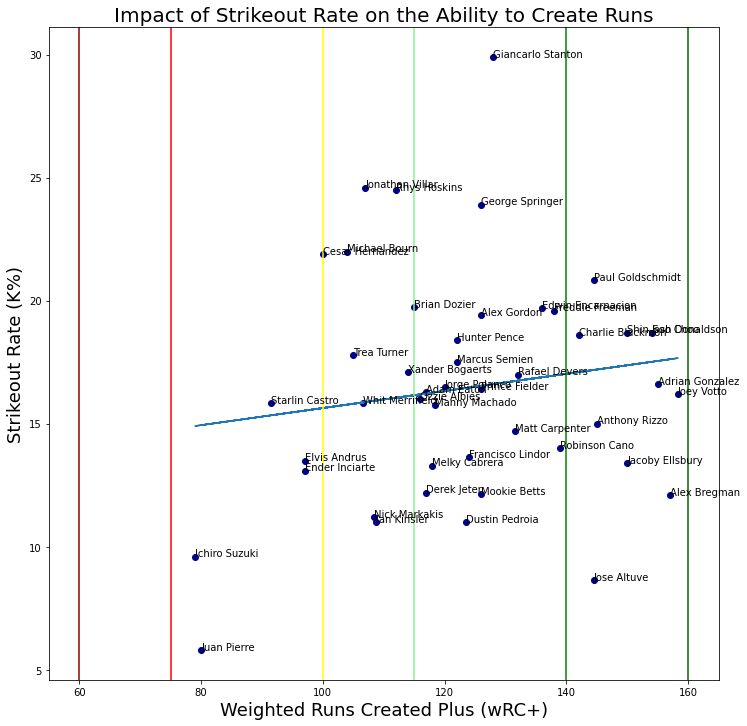

In [82]:
batting = batting_table.apply(pd.to_numeric, errors='ignore')
batting = batting[batting.PA  > 700].reset_index(drop=True)

batting = batting.groupby('Name').mean().reset_index()

# Set up plot
#batting_2021.plot(x='OPS',y='wRC+')
plt.title('Impact of Strikeout Rate on the Ability to Create Runs', fontsize=20)
plt.xlabel("Weighted Runs Created Plus (wRC+)", fontsize=18)
plt.ylabel("Strikeout Rate (K%)", fontsize=18)
plt.scatter(batting['wRC+'], batting['K%'], c = 'DarkBlue')
plt.gcf().set_size_inches((12, 12)) 

# Label data points
for idx, row in batting.iterrows():
    plt.annotate(row['Name'], (row['wRC+'], row['K%']))
    
# Calculate regression line and plot it in the same graph
reg = np.polyfit(batting['wRC+'], batting['K%'], 1)
reg_fnc = np.poly1d(reg)

m_list = []
p_list = []
for i in range(0, batting.shape[0]):
    wRC_plus = batting.at[i, 'wRC+']
    m_list.append(wRC_plus)
    p_list.append(reg_fnc(wRC_plus))

plt.plot(m_list, p_list)

# Plot lines of excellence -- Values courtesy of Fangraphs
plt.axvline(x=160, c = 'DarkGreen')   # Excellent
plt.axvline(x=140, c = 'Green')       # Great
plt.axvline(x=115, c = 'LightGreen')  # Above Average
plt.axvline(x=100, c = 'Yellow')      # Average
plt.axvline(x=75, c = 'Red')          # Poor
plt.axvline(x=60, c = 'DarkRed')      # Awful

plt.show()

In [ ]:
batting_table[batting_table.Name == 'Kris Bryant']